In [1]:
import os
import warnings
import time

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve
from astropy import units as u 

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures, angular_to_pixel
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments
from lcbg.photometry import flux_to_abmag
from lcbg.cosmology import cosmo_aperture_diameter

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Determine a Good Cutout Coord for Noise Estimate

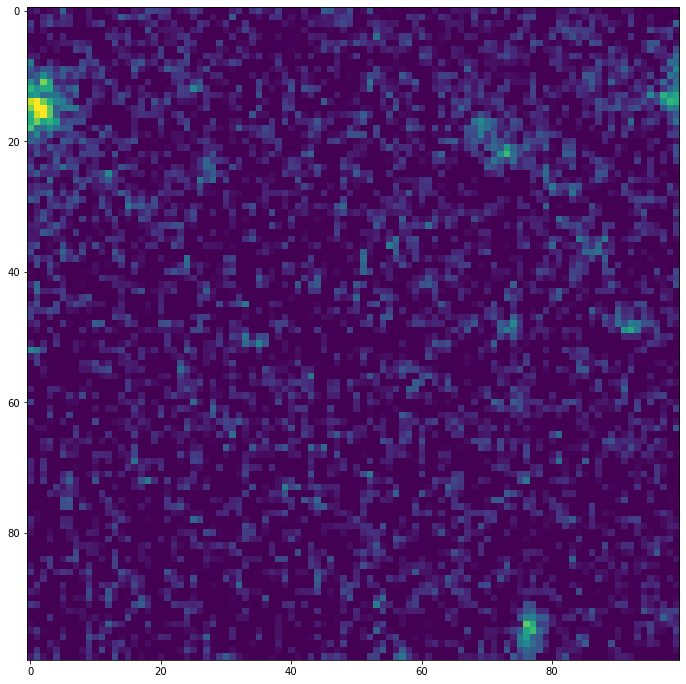

In [7]:
input_data_path = input_data_formatter.format('f105w')

hdul = fits.open(input_data_path)
hdu = hdul[0]

data = hdu.data
header = hdu.header
wcs = WCS(header)

subsection = cutout(data, 2779, 3390,  100)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)


# Do Aperture Photomerty

In [143]:
for current_filter in  filter_list:
    print(current_filter)
    
    # Load data and vitals
    # ---------------------
    
    input_data_path = input_data_formatter.format(current_filter)
    output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

    hdul = fits.open(input_data_path)
    hdu = hdul[0]

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    
    # Cutout Image
    # ------------
    
    # Estimate data noise
    subsection = cutout(data, 2779, 3390,  150)
    mean_noise = subsection.mean()
    
    # Select and crop image:
    cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
    image = cutout(data, cx, cy, 1000)
    
    image_wcs = wcs.copy()
    delta_pix = np.array([cx, cy]) - np.array(image.shape)//2
    image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix
    
    image -= mean_noise
    image = np.clip(image, 0, image.max())
    

    # Catalog
    # -------
    
    #nsigma = np.zeros_like(image) + image.mean() / 3
    nsigma = np.unique(detect_threshold(image, nsigma=3.))[0]
    segm = make_segments(image, nsigma=nsigma, kernel_size=None)
    
    segm_deblend = deblend_segments(image, segm)
    #plot_segments(segm_deblend, image)

    cat = source_properties(image, segm_deblend, wcs=image_wcs)
    
    # Photomerty
    # ----------
    """
    r_list = np.logspace(np.log10(0.06),np.log10(4), 50) * u.arcsec # approximate isophotal extent
    r_list = angular_to_pixel(r_list, wcs=wcs) # convert to pixels
    r_list = np.unique(np.round(r_list).astype(int)) # convert to int 
    """
    r_list = list(range(1,21))
    annulus_inner = 1
    annulus_outter = 2
    
    single_aperture_photometry_table = cat.to_table()
    for i, r in enumerate(r_list):
        print("{:0.2f}% : r={:0.2f}".format(100*i/len(r_list), r))
        
        aperture_photometry_results = []
        for obj in cat:
            position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
            
            a = r #obj.semimajor_axis_sigma.value * r
            b = r #obj.semiminor_axis_sigma.value * r
            theta = obj.orientation.to(u.rad).value

            aperture = EllipticalAperture(position, a, b, theta=theta)
            annulus = EllipticalAnnulus(position, 
                                        r_list[-1]*annulus_inner, #a*annulus_inner, 
                                        r_list[-1]*annulus_outter, #a*annulus_outter, 
                                        r_list[-1]*annulus_outter, #b*annulus_outter, 
                                        theta=theta)
            
            masked_image = image.copy()
            masked_image[((segm_deblend.data != 0 ) & (segm_deblend.data != obj.id))] = np.nan
            
            photometric_sum = aperture.do_photometry(masked_image)[0][0] 
            #photometric_bkg = aperture.area * (annulus.do_photometry(masked_image)[0][0] / annulus.area)
            
            """
            mask = annulus.to_mask(method='center')
            annulus_data = mask.multiply(masked_image)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
            photometric_bkg = median_sigclip * aperture.area
            """

            photometric_value = photometric_sum# - photometric_bkg

            aperture_photometry_results.append(photometric_value)
        aperture_photometry_results = np.array(aperture_photometry_results)
        
    
        # Make and save final catalog
        # ---------------------------
        single_aperture_photometry_table['aperture_sum_{}'.format(r)] =  aperture_photometry_results
        single_aperture_photometry_table['ab_mag_{}'.format(r)] = flux_to_abmag(np.array(aperture_photometry_results), header)
    
    single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
    plt.show()
    break
print("done")

f105w
0.00% : r=1.00
5.00% : r=2.00
10.00% : r=3.00
15.00% : r=4.00
20.00% : r=5.00
25.00% : r=6.00
30.00% : r=7.00
35.00% : r=8.00
40.00% : r=9.00
45.00% : r=10.00
50.00% : r=11.00
55.00% : r=12.00
60.00% : r=13.00
65.00% : r=14.00
70.00% : r=15.00
75.00% : r=16.00
80.00% : r=17.00
85.00% : r=18.00
90.00% : r=19.00
95.00% : r=20.00
done


In [144]:
cat = Table.read("./hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz_catalog.csv")

In [145]:
cat.sort(keys="source_sum", reverse=1)
cat

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_1,ab_mag_1,aperture_sum_2,ab_mag_2,aperture_sum_3,ab_mag_3,aperture_sum_4,ab_mag_4,aperture_sum_5,ab_mag_5,aperture_sum_6,ab_mag_6,aperture_sum_7,ab_mag_7,aperture_sum_8,ab_mag_8,aperture_sum_9,ab_mag_9,aperture_sum_10,ab_mag_10,aperture_sum_11,ab_mag_11,aperture_sum_12,ab_mag_12,aperture_sum_13,ab_mag_13,aperture_sum_14,ab_mag_14,aperture_sum_15,ab_mag_15,aperture_sum_16,ab_mag_16,aperture_sum_17,ab_mag_17,aperture_sum_18,ab_mag_18,aperture_sum_19,ab_mag_19,aperture_sum_20,ab_mag_20
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
81,605.6067255320143,308.6742224286111,"3.5862899574629132,-30.40044696071051","3.586286925954974,-30.400449137766113",5669.054,None,None,None,None,473.0,731.0,96.0,437.0,0.01933324,16.310883,549.0,110.0,608.0,326.0,45122.0,119.84481083628529,2035.7089450151002,51.55384824916127,37.29746075674581,74.45937526534252,0.6903599234690613,0.2765339150535169,1.3822348010604713,1482.0266944720795,326.96855051196326,2566.873153726462,0.0006942624855303005,-0.00017687044506981152,0.0004008439353665418,0.6166482548105066,2.2005868311829158,25.412471594190592,8.82184553470972,23.904919245298924,19.9213185650331,23.02052266747034,35.56915660840667,22.391133949440505,55.96294872090304,21.899066394333275,81.27399847146768,21.493938802351558,111.78159615084115,21.147892101727624,147.80305375431695,20.84460935073258,189.79378919997714,20.573112877227228,238.2554991571307,20.32621053511322,294.06886703526584,20.097695247621353,358.7670360434297,19.881786536738602,434.56880811521216,19.67367149120196,525.7851970090802,19.466796981505603,636.6032309601793,19.259145772296733,771.7865686361861,19.050074827734527,929.5465926494676,18.848139960332688,1097.4213958332257,18.667884310603583,1258.2778474143431,18.519376491703433,1403.7312342573514,18.400607959837426
119,164.6394394115402,835.9881802328538,"3.5948099282092514,-30.391657997076933","3.594806895721055,-30.391660173288628",2811.171,None,None,None,None,82.0,246.0,746.0,939.0,0.019338343,10.602837,240.0,792.0,165.0,837.0,19980.0,79.74855187369948,1063.2295808265224,27.73649010430654,19.47738503692829,-55.31299537598523,0.7119505278943868,0.2977703752824836,1.4240356213998615,505.6585913112717,-182.47442906016514,643.0228198717809,0.0022032413863286695,0.001250453954751456,0.0017325791578466818,0.6688394221304719,28.90275005713311,22.616469950352286,103.4123010593346,21.232387363831016,199.85582363180265,20.517025849075864,301.8729244843198,20.069257463146325,401.9377254482549,19.75842094216299,497.8954655143181,19.52597244087014,589.1805659217902,19.34319683538625,675.8154291717908,19.19424761174486,757.8301642997851,19.069888149155084,835.6662231551295,18.963735746607608,909.7325192859473,18.871533570291604,980.5553526906757,18.79013758154759,1048.550580570281,18.717344405855513,1113.977520929533,18.651626800344072,1177.037806169486,18.591841837220635,1237.8206572847475,18.537173553196425,1296.3057691235736,18.487049233887884,1352.4815604349171,18.44098948671816,1406.392387024518,18.39855160135731,1458.0131048653

In [146]:
mag_col_names = [i for i in cat.colnames if "aperture_sum_" in i]

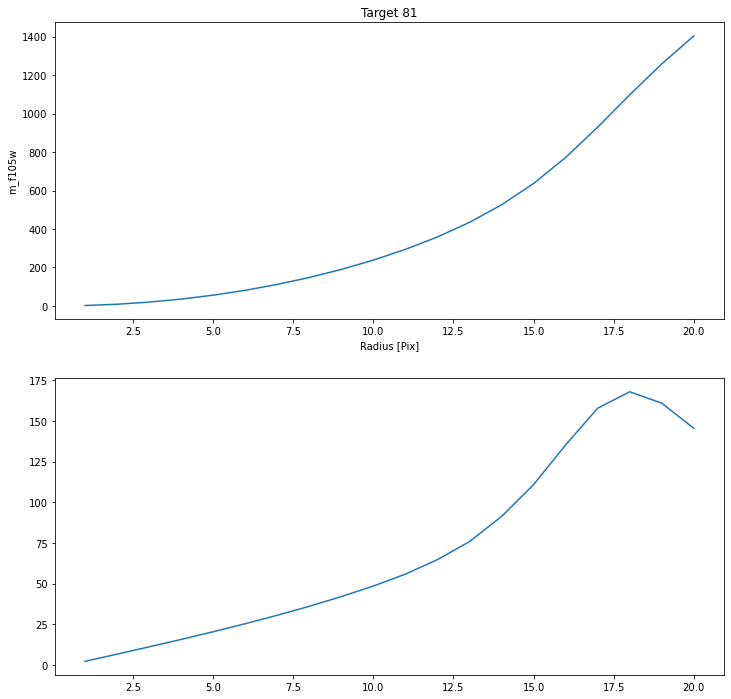

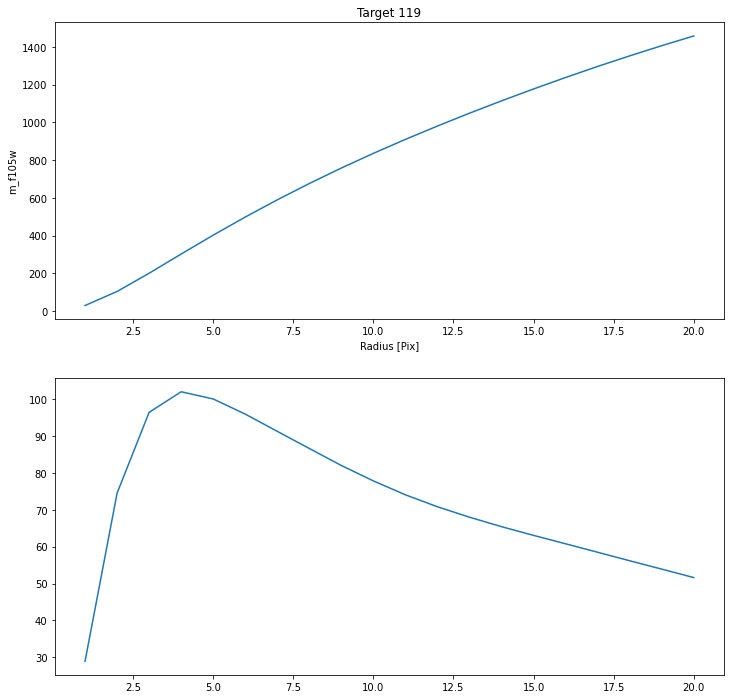

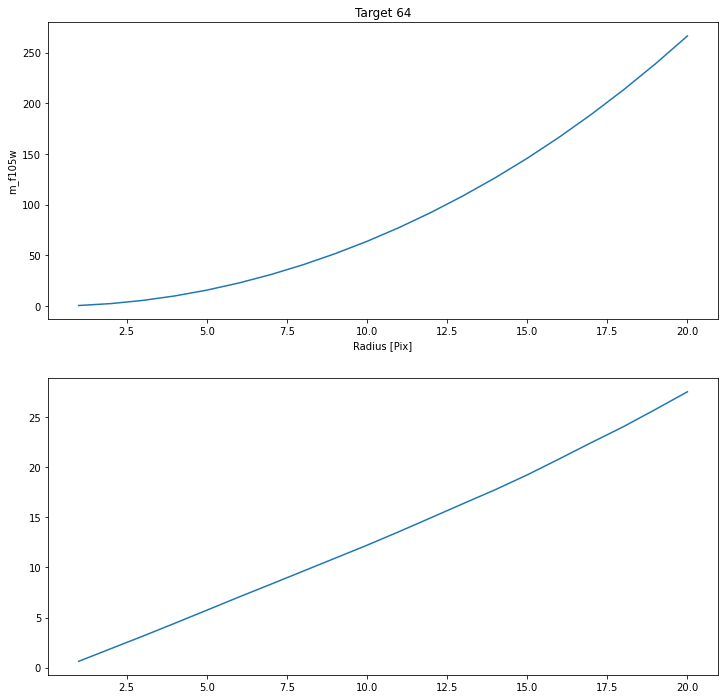

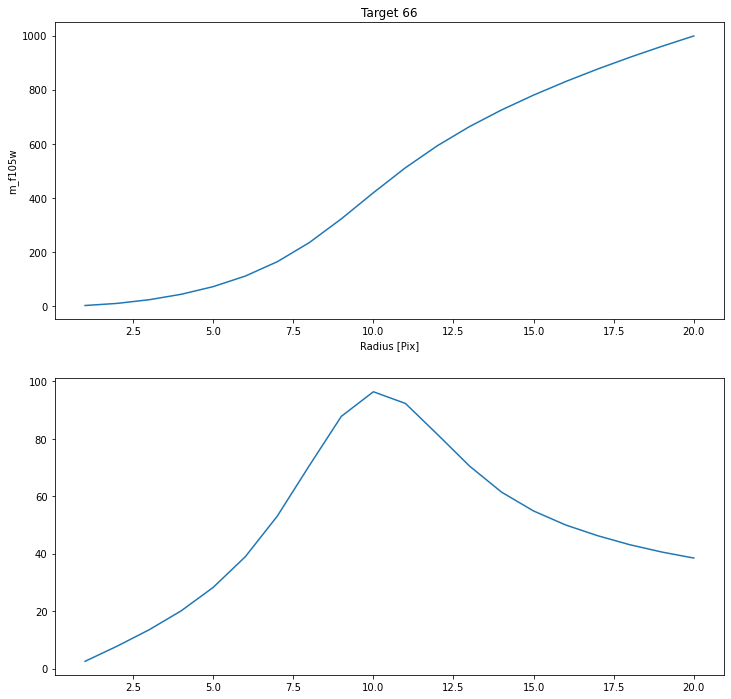

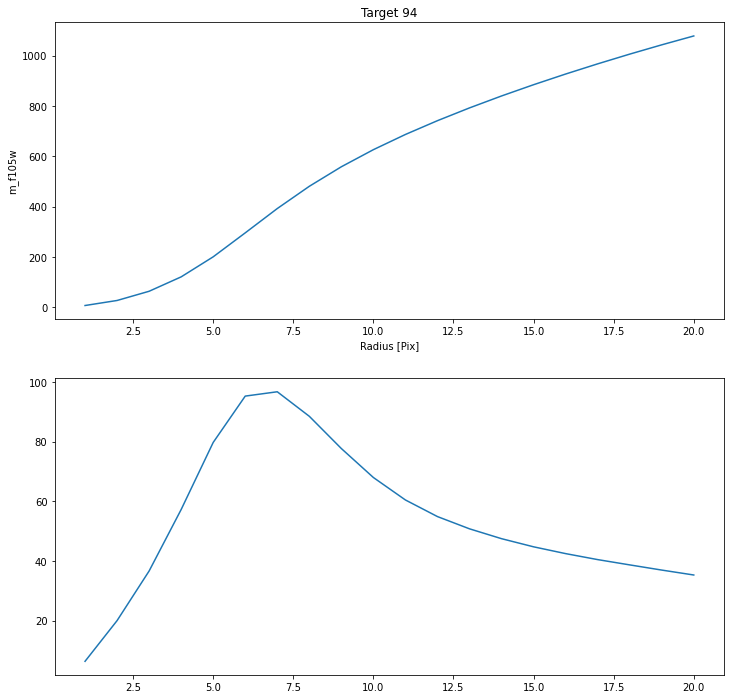

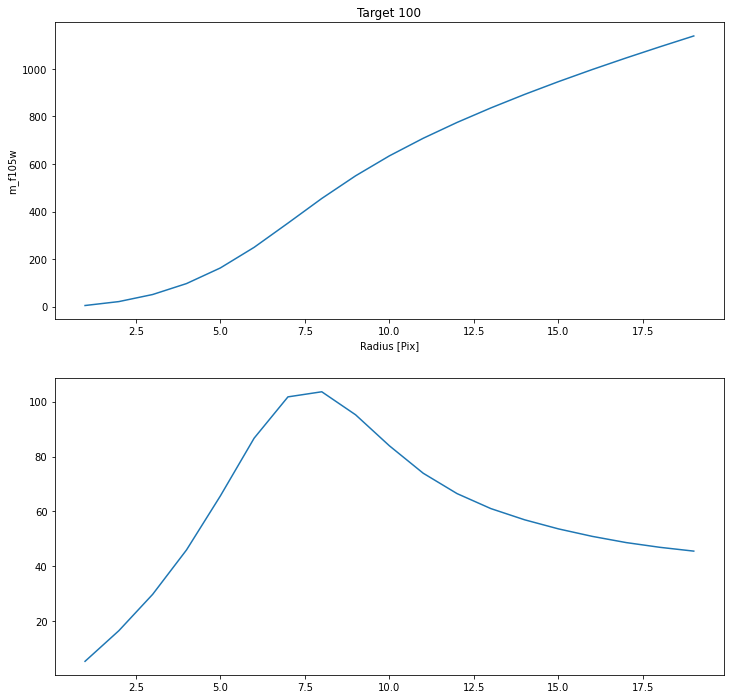

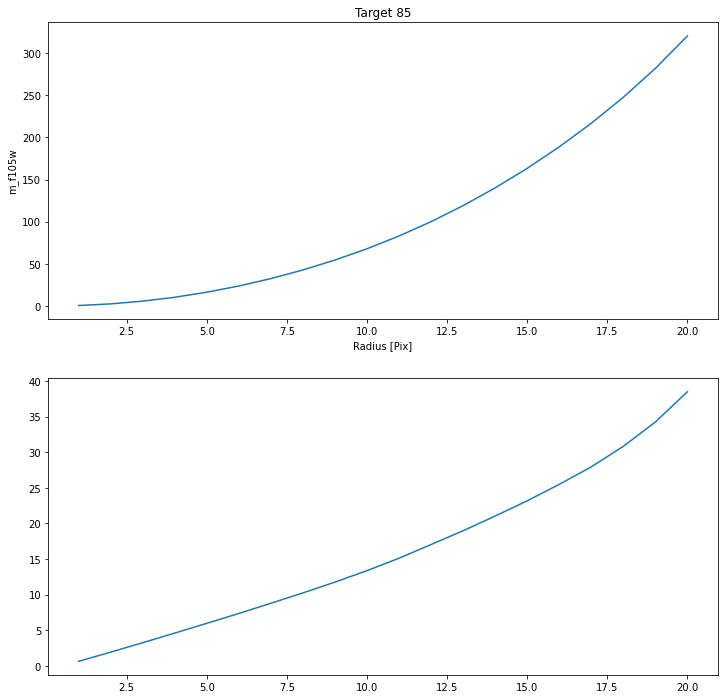

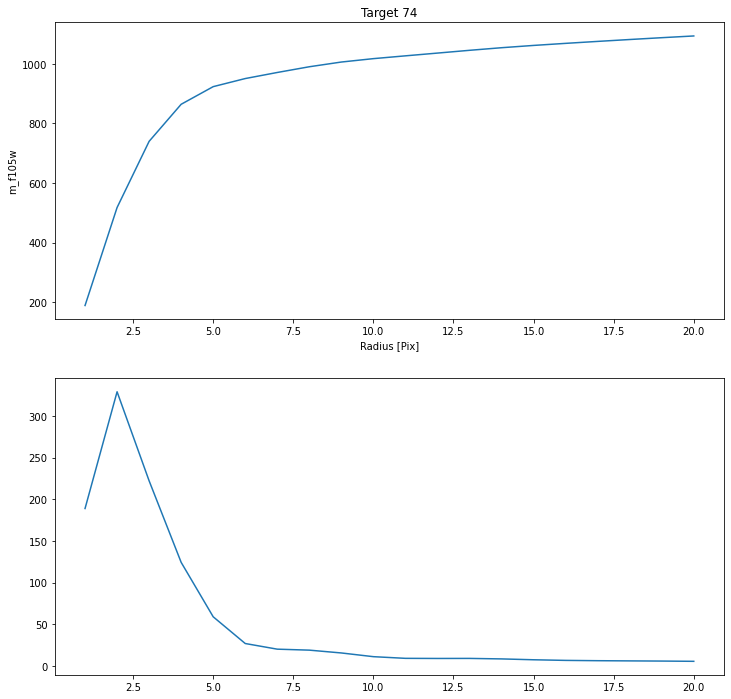

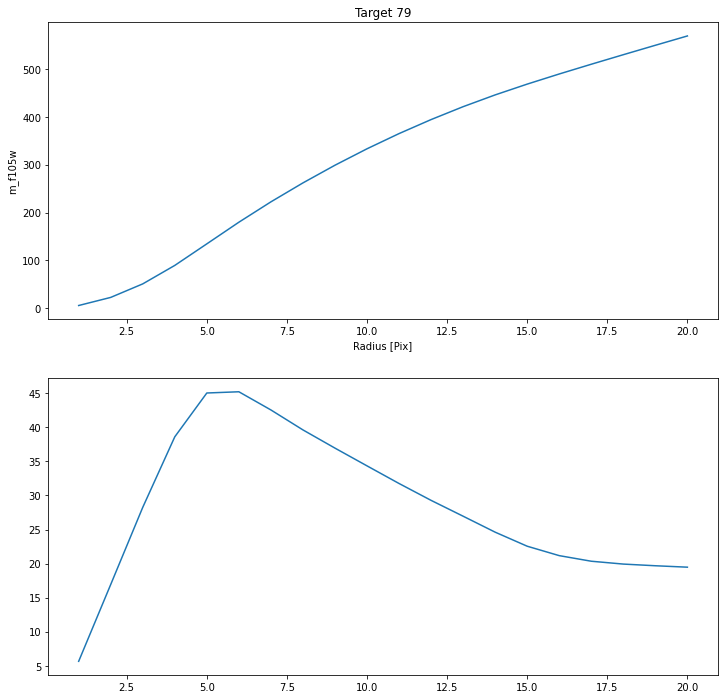

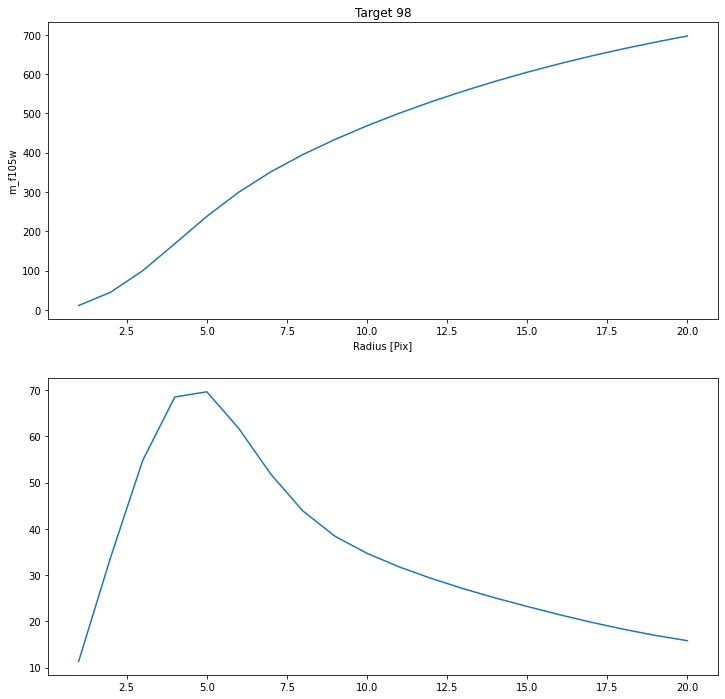

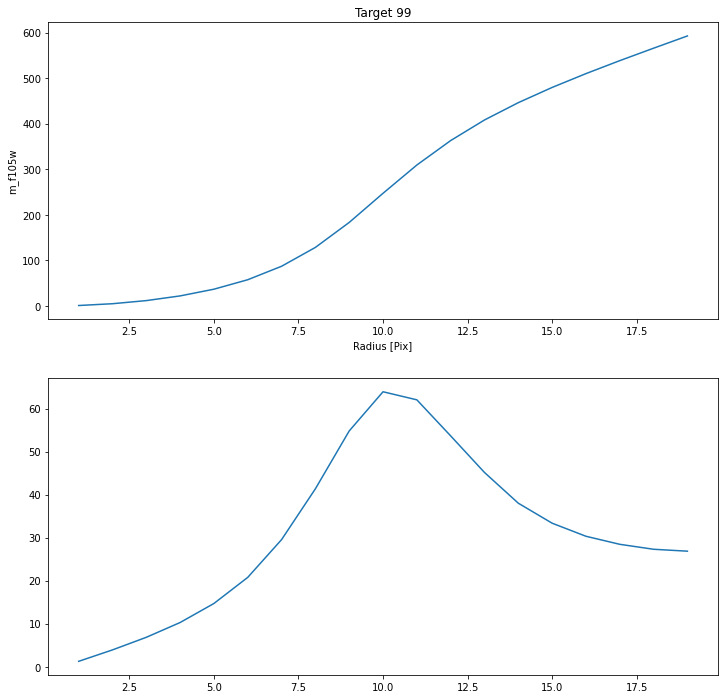

In [147]:
for idx, row in enumerate(cat):
    mags = list(row[mag_col_names])
    
    f, ax = plt.subplots(2, 1)
    
    ax[0].plot(r_list, mags)
    ax[0].set_title("Target "+str(row['id']))
    ax[0].set_xlabel("Radius [Pix]")
    ax[0].set_ylabel("m_f105w")
    
    y_values = []
    for i in range(len(mags)):
        if i == 0:
            y_values.append(mags[i])
            continue
        y_values.append(mags[i] - mags[i-1])    
    ax[1].plot(r_list, y_values, label="Raw")
    plt.show()
    if idx == 10:
        break
    print("\n"*2)

In [148]:
phot_table = cat
radii = r_list
phot_table

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_1,ab_mag_1,aperture_sum_2,ab_mag_2,aperture_sum_3,ab_mag_3,aperture_sum_4,ab_mag_4,aperture_sum_5,ab_mag_5,aperture_sum_6,ab_mag_6,aperture_sum_7,ab_mag_7,aperture_sum_8,ab_mag_8,aperture_sum_9,ab_mag_9,aperture_sum_10,ab_mag_10,aperture_sum_11,ab_mag_11,aperture_sum_12,ab_mag_12,aperture_sum_13,ab_mag_13,aperture_sum_14,ab_mag_14,aperture_sum_15,ab_mag_15,aperture_sum_16,ab_mag_16,aperture_sum_17,ab_mag_17,aperture_sum_18,ab_mag_18,aperture_sum_19,ab_mag_19,aperture_sum_20,ab_mag_20
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
81,605.6067255320143,308.6742224286111,"3.5862899574629132,-30.40044696071051","3.586286925954974,-30.400449137766113",5669.054,None,None,None,None,473.0,731.0,96.0,437.0,0.01933324,16.310883,549.0,110.0,608.0,326.0,45122.0,119.84481083628529,2035.7089450151002,51.55384824916127,37.29746075674581,74.45937526534252,0.6903599234690613,0.2765339150535169,1.3822348010604713,1482.0266944720795,326.96855051196326,2566.873153726462,0.0006942624855303005,-0.00017687044506981152,0.0004008439353665418,0.6166482548105066,2.2005868311829158,25.412471594190592,8.82184553470972,23.904919245298924,19.9213185650331,23.02052266747034,35.56915660840667,22.391133949440505,55.96294872090304,21.899066394333275,81.27399847146768,21.493938802351558,111.78159615084115,21.147892101727624,147.80305375431695,20.84460935073258,189.79378919997714,20.573112877227228,238.2554991571307,20.32621053511322,294.06886703526584,20.097695247621353,358.7670360434297,19.881786536738602,434.56880811521216,19.67367149120196,525.7851970090802,19.466796981505603,636.6032309601793,19.259145772296733,771.7865686361861,19.050074827734527,929.5465926494676,18.848139960332688,1097.4213958332257,18.667884310603583,1258.2778474143431,18.519376491703433,1403.7312342573514,18.400607959837426
119,164.6394394115402,835.9881802328538,"3.5948099282092514,-30.391657997076933","3.594806895721055,-30.391660173288628",2811.171,None,None,None,None,82.0,246.0,746.0,939.0,0.019338343,10.602837,240.0,792.0,165.0,837.0,19980.0,79.74855187369948,1063.2295808265224,27.73649010430654,19.47738503692829,-55.31299537598523,0.7119505278943868,0.2977703752824836,1.4240356213998615,505.6585913112717,-182.47442906016514,643.0228198717809,0.0022032413863286695,0.001250453954751456,0.0017325791578466818,0.6688394221304719,28.90275005713311,22.616469950352286,103.4123010593346,21.232387363831016,199.85582363180265,20.517025849075864,301.8729244843198,20.069257463146325,401.9377254482549,19.75842094216299,497.8954655143181,19.52597244087014,589.1805659217902,19.34319683538625,675.8154291717908,19.19424761174486,757.8301642997851,19.069888149155084,835.6662231551295,18.963735746607608,909.7325192859473,18.871533570291604,980.5553526906757,18.79013758154759,1048.550580570281,18.717344405855513,1113.977520929533,18.651626800344072,1177.037806169486,18.591841837220635,1237.8206572847475,18.537173553196425,1296.3057691235736,18.487049233887884,1352.4815604349171,18.44098948671816,1406.392387024518,18.39855160135731,1458.0131048653

In [149]:
cutout_size = int(round(radii[-1]*1))
cutout_size, image.shape

(20, (1000, 1000))

In [150]:
def slider(x):
    cutout_size = 240*2#int(round(radii[-1]*1))
    
    row = phot_table[x]
    target = cutout(image, 
                    int(round(phot_table[x]['xcentroid'])), 
                    int(round(phot_table[x]['ycentroid'])),
                    cutout_size)
    
    cutout_size = target.shape[0]
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(target, vmin=vmin, vmax=vmax)
    ax[0,0].set_title("Target".format(vmax))
    
    ax[0,1].imshow(np.clip(target, 0, target.max()), vmin=vmin, vmax=vmax)
    ax[0,1].set_title("Target [CircularAnnulus Subtracted]")
    
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    
    for r in radii:
        CircularAperture(position, r=r).plot(ax[0,0], color='w')
        CircularAperture(position, r=r).plot(ax[0,1], color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,0], color='r')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,1], color='r')
    
    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = list(row[mag_col_names])
    ax[1,0].plot(radii, y_values, label="Raw")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = []
    phot_values = list(row[mag_col_names])
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, label="Raw") 
    
    y_values = []
    phot_values = list(row[mag_col_names])
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, linestyle='--', label="Bkg Subtracted") 
    
    ax[1,1].set_title("Photometic Density")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Sum")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    cutout_size = radii[-1] * 2
    target = cutout(image, 
                    int(round(phot_table[x][1])), 
                    int(round(phot_table[x][2])),
                    cutout_size)
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    
    plt.imshow(target)
    for r in radii:
        CircularAperture(position, r=r).plot(plt.gca(), color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(plt.gca(), color='r')


    plt.show()

vmin = 0
vmax = image.mean()*10
#widgets.interact_manual(slider, x=widgets.IntSlider(min=0, max=len(phot_table)-1));
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(phot_table)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=127), Output()), _dom_classes=('widget-inte…

In [ ]:
#plot_segments(segm_deblend, image, vmax=image.mean()*6)

In [14]:
from astropy.wcs.utils import proj_plane_pixel_scales

In [17]:
angular_diameter = 14*u.arcsec
pixel_scales = proj_plane_pixel_scales(wcs)
assert np.allclose(*pixel_scales)
pixel_scale = pixel_scales[0] * wcs.wcs.cunit[0] / u.pix

pixel_size = angular_diameter / pixel_scale.to(angular_diameter.unit / u.pix)
pixel_size = pixel_size.value
pixel_size


233.33337659191358

In [18]:
angular_to_pixel(angular_diameter, wcs)

233.33337659191358

In [22]:
r_list =# * u.arcsec 
r_list

array([ 0.06      ,  0.06706212,  0.07495548,  0.08377789,  0.09363872,
        0.10466019,  0.11697892,  0.13074758,  0.14613684,  0.16333745,
        0.1825626 ,  0.2040506 ,  0.22806778,  0.25491183,  0.28491548,
        0.31845062,  0.35593292,  0.39782697,  0.44465202,  0.49698849,
        0.55548507,  0.62086681,  0.69394412,  0.77562278,  0.86691519,
        0.96895291,  1.08300068,  1.2104721 ,  1.35294718,  1.51219187,
        1.69017999,  1.88911768,  2.11147075,  2.35999524,  2.63777157,
        2.94824275,  3.29525704,  3.68311563,  4.11662598,  4.60116139,
        5.14272763,  5.74803734,  6.42459326,  7.18078121,  8.02597405,
        8.97064785, 10.02651171, 11.20665293, 12.52569922, 14.        ])

# Compare Catalogs

In [112]:
astro_deep_cat = Table.read("https://stsci.box.com/shared/static/2dsckrbt7b4eocl2v2mot9ssso0stc11.cat", format="ascii")

Mean[MAG_Y105]: -0.032826992449564524
Mean[MAG_J125]: -0.028791166160849133
Mean[MAG_JH140]: -0.058600086241409326
Mean[MAG_H160]: -0.05613464998700826


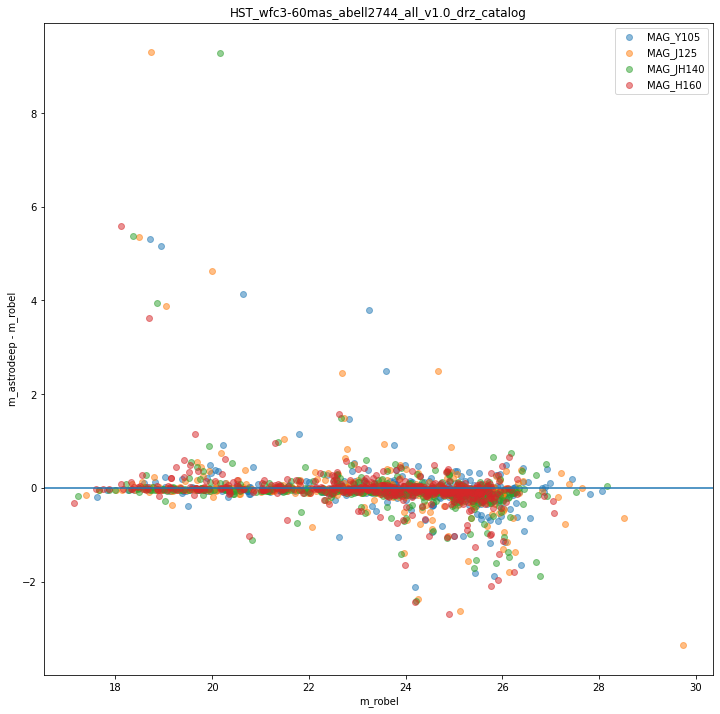

In [117]:
coords = []
for filt, ad_filt in zip(filter_list, ad_filter_list):
    cat = Table.read("hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz_catalog.csv".format(filt), format='ascii.csv')
    
    ad_values = []
    cat_values = []
    for row in cat:
        ra, dec = [float(i) for i in row['sky_centroid'].split(',')]
        mag = row['ab_mag']

        coord_delta = ((astro_deep_cat['RA'] - ra)**2 + (astro_deep_cat['DEC'] - dec)**2)
        idx = coord_delta.argmin()
        
        if coord_delta[idx] > 1e-8:
            continue
        
        ad_mag = astro_deep_cat[idx][ad_filt]

        if ad_mag < 99 and  -10 < (ad_mag - mag) < 10:
            ad_values.append(ad_mag - mag)
            cat_values.append(mag)
            
    plt.scatter(cat_values, ad_values, alpha=0.5, label=ad_filt)
    print("Mean[{}]:".format(ad_filt), np.array(ad_values).mean())
            
plt.axhline(0)
plt.legend()
plt.title("HST_wfc3-60mas_abell2744_all_v1.0_drz_catalog")
plt.xlabel("m_robel")
plt.ylabel("m_astrodeep - m_robel");

#plt.savefig('HST_wfc3-60mas_abell2744_all_v1.0_drz_catalog.png', dpi=500)

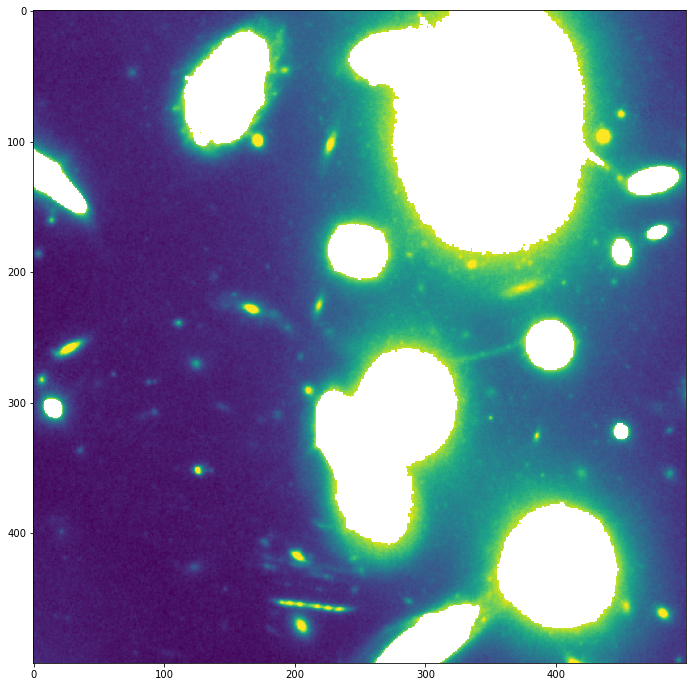

In [87]:
image_residual = image.copy()
image_residual[((segm_deblend.data != 0 ) & (segm_deblend.data != 2))] = np.nan
plt.imshow(image_residual, vmax=image.mean(), vmin=0)